In [36]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import t
import random
from sklearn.linear_model import Lasso

np.random.seed(0)


In [37]:

n_samples = 500
n_features = 5
n_simulations = 10000
std_noise_data = 10
lasso_alpha = 1

beta_true_values = np.zeros(n_features) 
X_raw_no_intercept = np.random.normal(0, 1, size=(n_samples, n_features))

def create_data_with_signal_lasso(X_input, true_betas, std_noise, intercept_val):
    linear_component = X_input @ true_betas
    noise = np.random.normal(0, std_noise, size=X_input.shape[0])
    y = intercept_val + linear_component + noise
    return y

def calculating_p_values(X_active, y, beta_hat_active, intercept_hat):
    n, p_active = X_active.shape
    if p_active == 0:
        return np.array([])
    if n <= p_active:
        return np.full(p_active, np.nan)
    
    residual = y - X_active @ beta_hat_active - intercept_hat
    sigma_squared = (residual.T @ residual) / (n - p_active - 1)
    X_design = np.c_[np.ones(n), X_active]
    var_beta_hat_full = sigma_squared * np.linalg.inv(X_design.T @ X_design)
    var_beta_hat = np.diag(var_beta_hat_full)[1:]
    se_beta = np.sqrt(var_beta_hat)
    t_stats = np.divide(beta_hat_active.flatten(), se_beta, 
                        out=np.zeros_like(beta_hat_active.flatten()), where=se_beta!=0)
    p_values = 2 * (1 - t.cdf(np.abs(t_stats), df = n - p_active - 1))
    return p_values

def fit_lasso_model(X, y, lam, max_iter = 7000, tol = 1e-5):
    def soft_thresolding(rho, lam, z):
        if rho < -lam:
            return (rho + lam)/z
        elif rho > lam:
            return (rho - lam)/z
        else:
            return 0
    n, p = X.shape
    beta = np.random.uniform(size = p)
    residual = y - X @ beta
    intercept = 0
    for iter in range(max_iter):
        beta_old = beta.copy()
        intercept_old = intercept
        for j in range(p):
            r_j = residual + X[:, j] * beta[j]
            rho = 1/n * X[:, j].T @ r_j
            z = 1/n * (X[:, j] ** 2).sum()

            beta[j] = soft_thresolding(rho, lam, z)
            residual = r_j - X[:, j] * beta[j]
        if np.linalg.norm(beta - beta_old, ord=1) < tol and abs(intercept - intercept_old) < tol:
            break
        intercept = np.mean(y) - np.sum(np.mean(X, axis = 0) * beta) 
    return beta, intercept


In [38]:

p_values_list_lasso = []
beta_hat_list_lasso = [] 
randomly_selected_pvalues_list_lasso = []
selection_counts = np.zeros(n_features) 


for i in range(n_simulations):

    intercept_true = 2 
    current_y = create_data_with_signal_lasso(X_raw_no_intercept, beta_true_values, std_noise_data, intercept_true)

    # lasso = Lasso(alpha=lasso_alpha, fit_intercept=True)
    # lasso.fit(X_raw_no_intercept, current_y)

    # beta_hat_lasso = lasso.coef_
    # intercept_hat_lasso = lasso.intercept_

    beta_hat_lasso, intercept_hat_lasso = fit_lasso_model(X_raw_no_intercept, current_y, lam = lasso_alpha)
    
    beta_hat_list_lasso.append(beta_hat_lasso)

    active_set_indices = np.where(np.abs(beta_hat_lasso) > 0.1)[0]
    selection_counts[active_set_indices] += 1

    p_values_sim = np.full(n_features, np.nan)

    if len(active_set_indices) > 0:
        X_active = X_raw_no_intercept[:, active_set_indices]
        beta_hat_active = beta_hat_lasso[active_set_indices]
        p_values_active = calculating_p_values(X_active, current_y, beta_hat_active, intercept_hat_lasso)
        p_values_sim[active_set_indices] = p_values_active
        
        selected_p = random.choice(p_values_active)
        randomly_selected_pvalues_list_lasso.append(selected_p)

    p_values_list_lasso.append(p_values_sim)



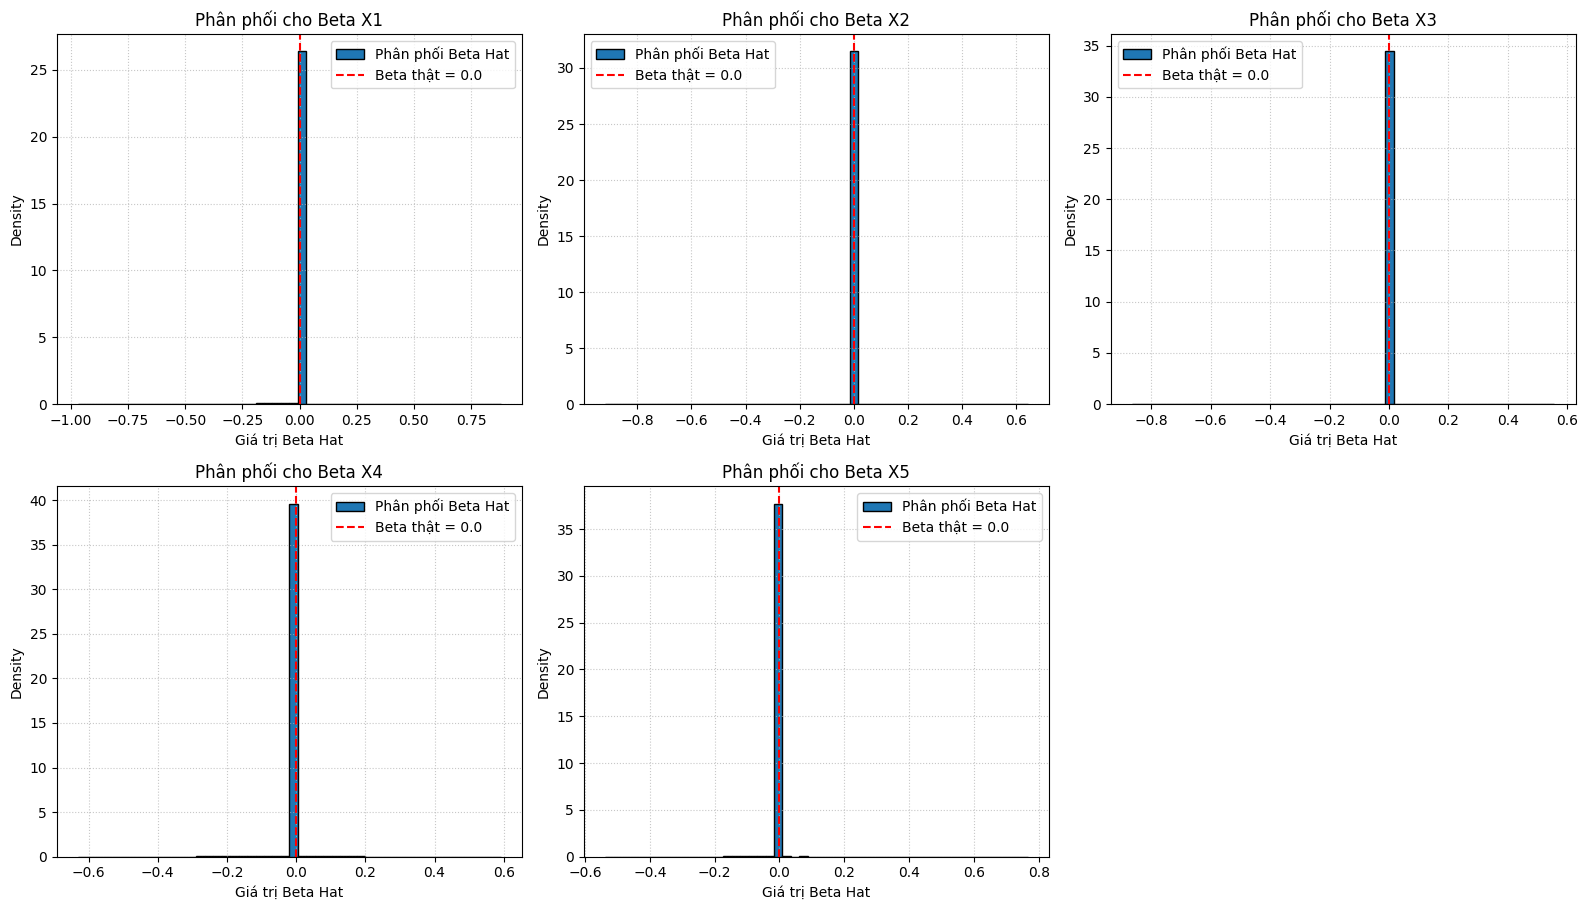

In [39]:

columns_beta = [f'Beta_X{i+1}' for i in range(n_features)]
beta_hat_df_lasso = pd.DataFrame(beta_hat_list_lasso, columns=columns_beta)

fig_beta, axes_beta = plt.subplots(2, 3, figsize=(16, 10))
axes_beta = axes_beta.flatten()

for idx, col_name in enumerate(columns_beta):
    ax = axes_beta[idx]
    
    ax.hist(beta_hat_df_lasso[col_name], bins=50, edgecolor='black', density=True, label='Phân phối Beta Hat')
    
    ax.axvline(beta_true_values[idx], color='red', linestyle='--', label=f'Beta thật = {beta_true_values[idx]}')
    
    ax.set_title(f'Phân phối cho {col_name.replace("_", " ")}')
    ax.set_xlabel('Giá trị Beta Hat')
    ax.set_ylabel('Density')
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.legend()

fig_beta.delaxes(axes_beta[-1])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


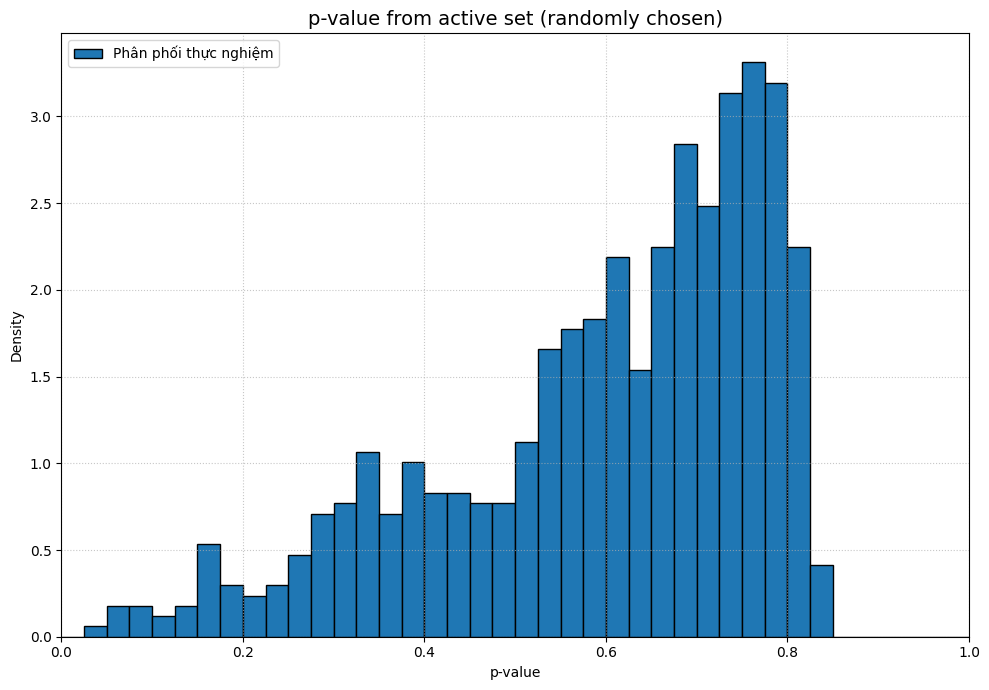

In [40]:


fig_rand_lasso, ax_rand_lasso = plt.subplots(figsize=(10, 7))

ax_rand_lasso.hist(randomly_selected_pvalues_list_lasso, bins=40, edgecolor='black', density=True,
                   range=(0,1), label='Phân phối thực nghiệm')

ax_rand_lasso.set_title('p-value from active set (randomly chosen)', fontsize=14)
ax_rand_lasso.set_xlabel('p-value')
ax_rand_lasso.set_ylabel('Density')
ax_rand_lasso.set_xlim(0, 1)
ax_rand_lasso.set_ylim(bottom=0)
ax_rand_lasso.grid(True, linestyle=':', alpha=0.7)
ax_rand_lasso.legend(loc='upper left')
plt.tight_layout()
plt.show()